In [16]:
# Open cv library
import cv2

# matplotlib for displaying the images 
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from math import exp, log, log10
import numpy as np
from PIL import Image
from collections import Counter

In [17]:
img = mpimg.imread(r"0.jpg")

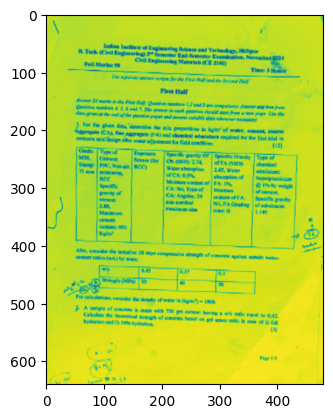

In [18]:
plt.imshow(img)

## We are taking the image data and seeing what is the array of the image

In [19]:
image_data=Image.open(r"0.jpg")
image_array = np.array(image_data)
image_array

array([[229, 229, 229, ..., 223, 228, 227],
       [229, 229, 229, ..., 223, 225, 224],
       [229, 229, 229, ..., 223, 220, 219],
       ...,
       [238, 238, 239, ..., 235, 235, 235],
       [237, 237, 238, ..., 235, 235, 235],
       [237, 238, 238, ..., 235, 235, 235]], dtype=uint8)

# Now we will separate the background from the foreground of the image
Here we are finding the value that is occurring the highest number of times and deciding it to be a background and then deciding the foreground by the value which is occurring minimum number of times for a black and white image

In [20]:
unique_elements=np.unique(image_array)

In [21]:
unique_elements

array([ 32,  33,  35,  36,  37,  41,  44,  46,  47,  50,  51,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
       199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
       212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 22

In [22]:
def find_max_min_elements(arr):
    # Flatten the 2D array and get unique elements with counts
    elements, counts = np.unique(arr, return_counts=True)
    
    # Find elements with maximum count
    max_count = np.max(counts)
    max_elements = elements[counts == max_count]
    
    # Find elements with minimum count
    min_count = np.min(counts)
    min_elements = elements[counts == min_count]
    
    return max_elements, max_count, min_elements, min_count

In [23]:
max_elements, max_count, min_elements, min_count = find_max_min_elements(image_array)

print(f"Element(s) with maximum count ({max_count}): {max_elements}")
print(f"Element(s) with minimum count ({min_count}): {min_elements}")

Element(s) with maximum count (20200): [226]
Element(s) with minimum count (1): [32 33 35 37 41 44 50 51 55 57 66]


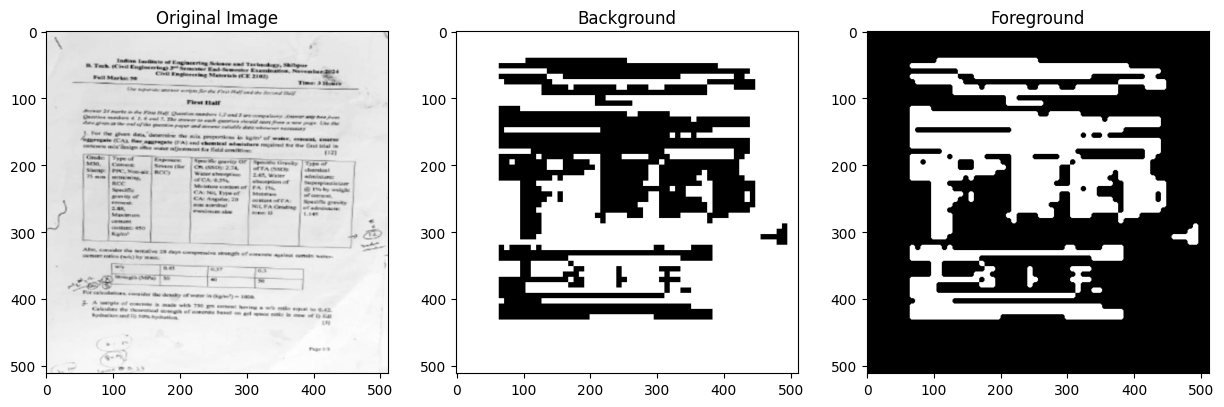

In [26]:
class Node:
    def __init__(self, x0, y0, w, h):
        self.x0 = x0
        self.y0 = y0
        self.width = w
        self.height = h
        self.children = []
        
    def get_region(self):
        return (self.x0, self.y0, self.width, self.height)
    
    def get_error(self, img):
        region = img[self.x0:self.x0+self.width, self.y0:self.y0+self.height]
        return np.std(region)  # Using standard deviation as homogeneity measure

class QTree:
    def __init__(self, img, threshold, min_size):
        self.root = Node(0, 0, img.shape[0], img.shape[1])
        self.threshold = threshold
        self.min_size = min_size
        self.img = img
        self.leaf_nodes = []
        
    def subdivide(self):
        self._recursive_subdivide(self.root)
        
    def _recursive_subdivide(self, node):
        if node.width < self.min_size or node.height < self.min_size:
            self.leaf_nodes.append(node)
            return
            
        current_error = node.get_error(self.img)
        if current_error <= self.threshold:
            self.leaf_nodes.append(node)
            return
            
        # Split into 4 quadrants
        w1, w2 = node.width//2, node.width - node.width//2
        h1, h2 = node.height//2, node.height - node.height//2
        
        node.children = [
            Node(node.x0, node.y0, w1, h1),
            Node(node.x0, node.y0+h1, w1, h2),
            Node(node.x0+w1, node.y0, w2, h1),
            Node(node.x0+w1, node.y0+h1, w2, h2)
        ]
        
        for child in node.children:
            self._recursive_subdivide(child)

def quadtree_segmentation(img_path, threshold=10, min_size=32):
    # Read and preprocess image
    img = cv2.imread(img_path, 0)  # Read as grayscale
    img = cv2.resize(img, (512, 512))  # Standardize size
    
    # Create quadtree and subdivide
    qt = QTree(img, threshold, min_size)
    qt.subdivide()
    
    # Create masks
    background = np.zeros_like(img)
    foreground = np.zeros_like(img)
    
    for node in qt.leaf_nodes:
        x, y, w, h = node.get_region()
        region = img[x:x+w, y:y+h]
        if node.get_error(img) <= threshold:
            background[x:x+w, y:y+h] = 255  # White for background
        else:
            foreground[x:x+w, y:y+h] = 255  # White for foreground
    
    # Post-processing
    foreground = cv2.medianBlur(foreground, 5)
    kernel = np.ones((3,3), np.uint8)
    foreground = cv2.morphologyEx(foreground, cv2.MORPH_CLOSE, kernel)
    
    # Visualization
    plt.figure(figsize=(15, 5))
    plt.subplot(131), plt.imshow(img, cmap='gray'), plt.title('Original Image')
    plt.subplot(132), plt.imshow(background, cmap='gray'), plt.title('Background')
    plt.subplot(133), plt.imshow(foreground, cmap='gray'), plt.title('Foreground')
    plt.show()
    
    return background, foreground

# Usage example
background, foreground = quadtree_segmentation('0.jpg', threshold=15, min_size=16)